In [1]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import asset.MyPlot as mp
import asset.DataSupply as ds

import warnings
warnings.filterwarnings("ignore")

#### load and inner-join level and flow data

In [2]:
df_OudeE_level_old = ds.GetData("Oude_Engelenseweg", isLevel = True, isNew = False)
df_OudeE_flow_old = ds.GetData("Oude_Engelenseweg", False, False)

100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


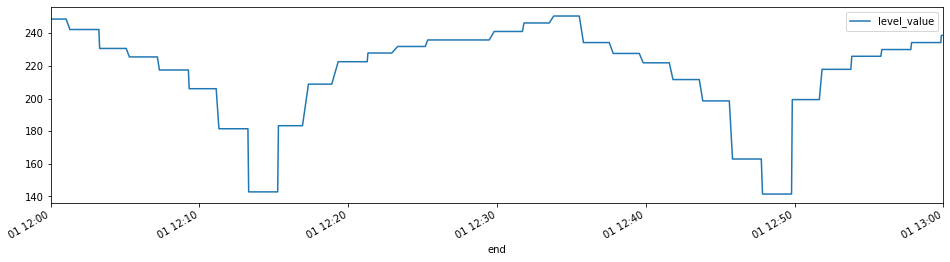

In [5]:
df_OudeE_level_old["2019-02-01 12:00:00":"2019-02-01 13:00:00"].plot(figsize=(16, 4))

#### smoothing level data, from stepped to continous

In [6]:
df_OudeE_level_old_r = ds.RoundDataPerMinuteStep(df_OudeE_level_old, isLevel=True)

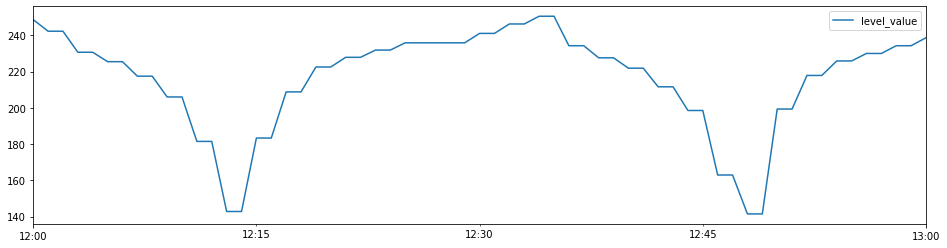

In [7]:
df_OudeE_level_old_r["2019-02-01 12:00:00":"2019-02-01 13:00:00"].plot(figsize=(16, 4))

In [8]:
df_OudeE_level_old_s = ds.WaterLevelSmoothing(df_OudeE_level_old_r)

875521it [01:10, 12336.03it/s]


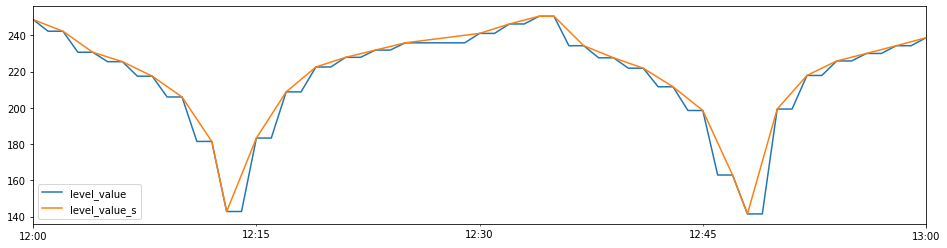

In [9]:
df_OudeE_level_old_s["2019-02-01 12:00:00":"2019-02-01 13:00:00"][
    ["level_value", "level_value_s"]
].plot(figsize=(16, 4))

#### inner-join level and flow data

In [10]:
df_join = df_OudeE_level_old_s.join(df_OudeE_flow_old, how="inner")
df_join.head(3)

,level_value,level_diff,level_value_s,level_diff_s,flow_quality,flow_value
2018-01-01 00:01:00,304.933,-0.667,305.266500,-0.333500,100,0.0
2018-01-01 00:02:00,304.933,0.000,304.933000,-0.333500,100,0.0
2018-01-01 00:03:00,304.533,-0.400,304.799667,-0.133333,100,0.0


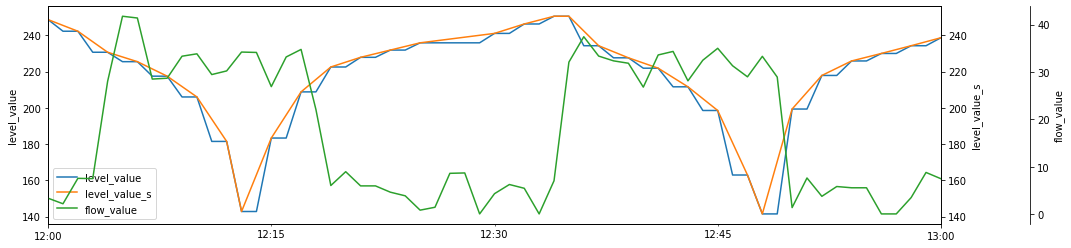

In [11]:
mp.PlotMulti(
    df_join[["level_value", "level_value_s", "flow_value"]][
        "2019-02-01 12:00:00":"2019-02-01 13:00:00"
    ],
    figsize=(16, 4),
)

#### mark level-flow data if dry-day

In [12]:
df_rain_historical, dct_areas = ds.GetRainfallByPumps(["Oude_Engelenseweg"])
location = dct_areas["oude_engelenseweg"][0]
target_col = f"{location}_dry"

100%|██████████| 22/22 [00:11<00:00,  1.93it/s]


In [13]:
df_rain_historical = ds.MarkDryWeather(df_rain_historical, location)

In [14]:
df_join["end_hour"] = df_join.index.ceil("h")
df_join["dry"] = False
for idx, row in tqdm(df_join.iterrows()):
    if df_rain_historical.at[row["end_hour"], target_col]:
        df_join.at[idx, "dry"] = True

863820it [01:36, 8964.75it/s] 


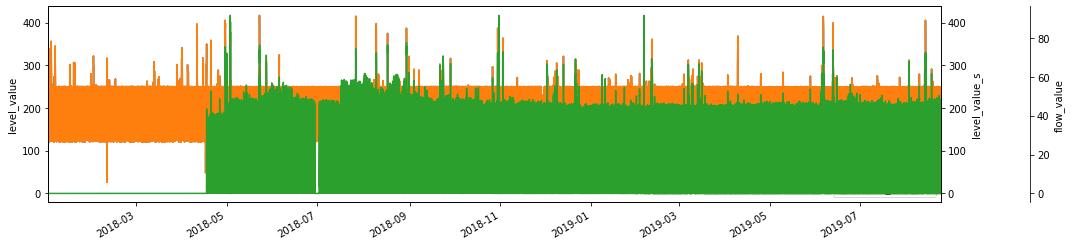

In [15]:
mp.PlotMulti(
    df_join[["level_value", "level_value_s", "flow_value"]],
    figsize=(16, 4),
)

In [16]:
df_dry = df_join[(df_join["dry"]) & (df_join["flow_quality"] == 100)][
    "2018-04-25 00:00:00":
].copy()

df_dry["adj_level_diff_s"] = df_dry["level_diff_s"]
df_dry.loc[(df_dry["adj_level_diff_s"] < 0), "adj_level_diff_s"] = np.nan

df_dry["adj_level_diff_s"] = (
    df_dry["adj_level_diff_s"].ffill() + df_dry["adj_level_diff_s"].bfill()
) / 2

df_dry["adj_level_diff_s"] = df_dry["adj_level_diff_s"].fillna(0)

#### estimate the how much volume (m3) water could increase 1 meter water level

In [17]:
def InitDict():
    return {
        "up1": None,
        "up2": 0,
        "level_up": 0,
        "out": [],
        "start_level": 0,
        "end_level": 0,
    }


td = timedelta(minutes=1)
t0 = datetime(1900, 1, 1)
lst_m3_per_m = []
dct = InitDict()
for idx, row in tqdm(df_dry.iterrows()):
    if idx - t0 > td:  # if time is continuous
        dct = InitDict()
    else:
        if row["level_diff_s"] < 0 and dct["up1"] != 0:  # down after up
            dct["out"].append(row["flow_value"])
        if len(dct["out"]) == 0:  # no pump-out be recorded
            if row["level_diff_s"] > 0:
                if dct["up1"] is None:
                    dct["start_level"] = row["level_value_s"]
                dct["up1"] = row["level_diff_s"]

        else:
            if row["level_diff_s"] > 0:
                dct["up2"] = row["level_diff_s"]
                sss = np.sum(dct["out"]) / (
                    dct["level_up"] - dct["end_level"] + dct["start_level"]
                )
                lst_m3_per_m.append(sss)  #  m3/m water-level
                dct = InitDict()
    t0 = idx
    dct["end_level"] = row["level_value_s"]
    dct["level_up"] += row["adj_level_diff_s"]

avg_m3_per_m = np.average(lst_m3_per_m)
print(f"every 1 meter waterlevel have {avg_m3_per_m} m3 water")

542735it [01:31, 5940.60it/s]


every 1 meter waterlevel have 3.5645440969469275 m3 water
